# Red sea balances

Here we will run the partial least squares balances on the red sea dataset, with the goal of performing regression.

In [1]:
import pandas as pd
from statsmodels.sandbox.stats.multicomp import multipletests
from skbio import TreeNode
from skbio.stats.composition import multiplicative_replacement
import seaborn as sns
import matplotlib.pyplot as plt
from gneiss.plot import balance_boxplot, balance_barplots, proportion_plot
from gneiss.util import match

from pls_balances.src.balances import balance_regression, round_balance
import qiime2
import numpy as np
import matplotlib

%matplotlib inline
np.random.seed(0)
#font = {'family' : 'norma
#        'size'   : 16}

#matplotlib.rc('font', **font)

In [2]:
data_dir = '../data/redsea'
table_file = '%s/all_samples_KOs_renorm_unstratified.tsv' % data_dir
metadata_file = '%s/krse2011_v5_metadata.csv' % data_dir

table = pd.read_table(table_file, index_col=0)
metadata = pd.read_csv(metadata_file, index_col=0)

sample_ids = list(map(lambda x: x.split('.')[0], table.columns))
table = pd.DataFrame(table.T.values, index=sample_ids, columns=table.index)
table = table.iloc[:, 2:]
table = pd.DataFrame(multiplicative_replacement(table.values),
                     index=table.index, columns=table.columns
)
#table = table + 1
table, metadata = match(table, metadata)


Now we will fit the Gaussian mixture models and attempt to evaluate how good the fit is.

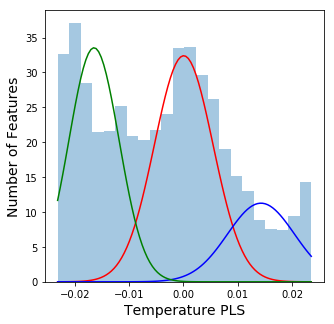

In [3]:
from sklearn.cross_decomposition import PLSRegression
from skbio.stats.composition import clr, centralize, multiplicative_replacement
from sklearn.mixture import GaussianMixture
from scipy.stats import norm
from gneiss.plot import mixture_plot

# log transform
ctable = pd.DataFrame(clr(centralize(table)), 
                      index=table.index, columns=table.columns)

fig, ax = plt.subplots(figsize=(5, 5))

# PLS on the colors
temp_pls = PLSRegression(n_components=1)
temp_pls.fit(X=ctable.values, Y=metadata.temperature)
temp_spectrum = pd.DataFrame(temp_pls.x_weights_, index=ctable.columns, columns=['PLS1'])
mixture_plot(temp_spectrum.values, ax=ax)
ax.set_ylabel('Number of Features', fontsize=14)
ax.set_xlabel('Temperature PLS', fontsize=14)
fig.savefig('../results/redsea_mixture.pdf')

In [4]:
from gneiss.regression import PLSRegressor

temp_model = PLSRegressor()
temp_slope, temp_r, temp_p, temp_cv = temp_model.fit(X=table, Y=metadata.temperature, num_folds=4)

In [5]:
temp_cv

,Q2
0,0.858696
1,0.932327
2,0.816063
3,0.834848


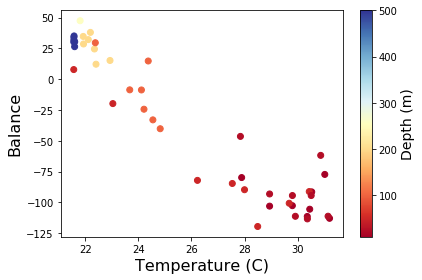

In [6]:
fig, ax = plt.subplots()
cm = plt.cm.get_cmap('RdYlBu')

sc = ax.scatter(metadata.temperature, temp_model.balance, c=metadata.depth, cmap=cm)
ax.set_xlabel('Temperature (C)', fontsize=16)
ax.set_ylabel('Balance', fontsize=16)
cbar = plt.colorbar(sc)
cbar.set_label(label='Depth (m)', fontsize=14)
plt.tight_layout()
fig.savefig('../results/redsea_regression.pdf')

In [7]:
writer = pd.ExcelWriter('../results/redsea_stats.xlsx')

stats = pd.Series([temp_cv['Q2'].mean(), temp_r, temp_p],
                  index=['Q2_CV', 'r', 'p'])
temp_cv['Q2'].to_excel(writer, sheet_name='cv', index_label='folds')
stats.to_excel(writer, sheet_name='summary', header=False)
writer.save()

Let's generate some proportion plots

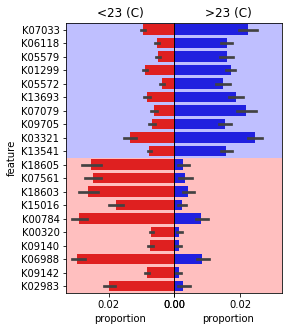

In [8]:
T = table.apply(lambda x: np.sqrt(x / x.sum()), axis=1)

num_temp = temp_model.numerator
denom_temp = temp_model.denominator

top_num_temp = temp_spectrum.sort_values(by='PLS1')[:10]
top_denom_temp = temp_spectrum.sort_values(by='PLS1')[-10:]
threshold = 23
cold, hot = '<%d (C)' % threshold, '>%d (C)' % threshold
def hot_metadata(x):
    if x['temperature'] > threshold:
        return hot
    else:
        return cold
temp_colors = {cold: '#FF0000', hot: '#0000FF'}
metadata['temp_cat'] = metadata.apply(hot_metadata, axis=1)
proportion_plot(T, metadata, category='temp_cat', 
                left_group=cold, right_group=hot,
                num_features=top_num_temp.index, 
                denom_features=top_denom_temp.index,
                num_color=temp_colors[hot],
                denom_color=temp_colors[cold], 
                figsize=(5, 5))
plt.savefig('../results/redsea_proportions.pdf', bbox_inches='tight', pad_inches=0)

In [9]:
# create the feature metadata for coloring the balances
def balance_part(x, num, denom):
    if x in num:
        return 'num'
    elif x in denom:
        return 'denom'
    else:
        return 'None'
num_temp = temp_model.numerator
denom_temp = temp_model.denominator

feature_metadata = pd.DataFrame({
    'temperature_PLS': temp_spectrum.PLS1,
    'temperature_part': [balance_part(x, num_temp, denom_temp) 
                         for x in table.columns]},
    index=table.columns)

feature_metadata.to_csv('../results/redsea_feature_metadata.csv')

In [14]:
import matplotlib

def rgb2hex(x):
    return '#%02x%02x%02x' % (int(x[0]*255), int(x[1]*255), int(x[2]*255))
f_ids = list(set(temp_spectrum.index))

n = len(num_temp) 
d = len(denom_temp)
o = len(f_ids) - n - d

cmap = matplotlib.cm.get_cmap('RdYlBu')
norm = matplotlib.colors.Normalize(vmin=metadata.temperature.min(), 
                                   vmax=metadata.temperature.max())
temperature_colors = pd.Series([rgb2hex(cmap(norm(i))) for i in metadata.temperature],
                               index=metadata.index, name='Temperature')

feature_colors = pd.Series([rgb2hex(cmap(0))]*n + [rgb2hex(cmap(1000))]*d + ['#D0D3D4']*o,
                           index=f_ids, name='Features')

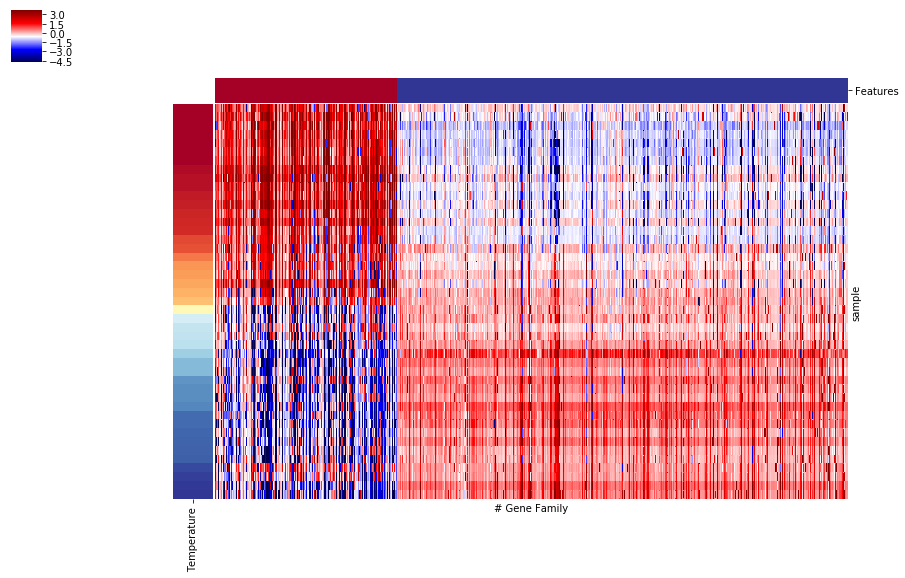

In [17]:
import seaborn as sns
ctable = ctable.reindex(columns=f_ids,
                        index=metadata.temperature.sort_values().index)
#plt.imshow(ctable.values, aspect='auto', interpolation='nearest', cmap='seismic')
feature_colors = pd.Series([rgb2hex(cmap(0))]*n + [rgb2hex(cmap(1000))]*d,
                           index=num_temp + denom_temp, name='Features')

G = sns.clustermap(ctable.loc[:, num_temp + denom_temp], 
                   row_cluster=False, col_cluster=False, 
                   row_colors=temperature_colors, 
                   col_colors=feature_colors, cmap='seismic', 
                   robust=True, figsize=(15, 9))
_ = G.ax_heatmap.set_xticks([])
_ = G.ax_heatmap.set_yticks([])
G.savefig('../results/figure3_redsea_heatmap_partial.pdf')